* This notebook was made to look at the alongshore, cross-starit transport of fresh water, total water amount of each run.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (
    nc_tools,
    viz_tools,
    tidetools,
)
import datetime, os
from glob import glob
from nowcast import figures
import matplotlib.pyplot as plt
import matplotlib as mpl
from R_mixStuff import sites
from R_mixStuff import strings
mpl.rcParams.update({'font.size': 24})
mpl.rcParams["axes.formatter.useoffset"] = False
%matplotlib inline

In [2]:
transects = {'1':{'jst':55, 'ist':25,'jen':56,'ien':80},
            '2':{'jst':25, 'ist':25,'jen':26,'ien':75},
            '3':{'jst':25, 'ist':25,'jen':56,'ien':26}}

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][380:510,240:397]
Y = grid6.variables['nav_lat'][380:510,240:397]
bathy = grid6.variables['Bathymetry'][380:510,240:397]

(48.95, 49.4)

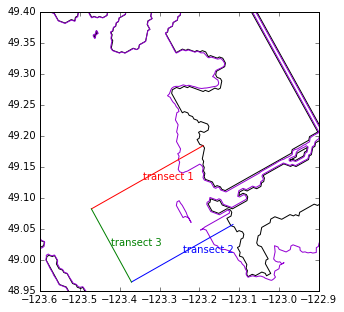

In [4]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
ax.plot(X[55,25:80],Y[55,25:80],'r')
ax.plot(X[25,25:75],Y[25,25:75],'b')
ax.plot(X[25:56,25],Y[25:56,25],'g')
ax.annotate ('transect 1',(X[55,50],Y[55,50]), xycoords="data",color = 'r')
ax.annotate ('transect 2',(X[25,50],Y[25,50]), xycoords="data",color = 'b')
ax.annotate ('transect 3',(X[40,25],Y[40,25]), xycoords="data",color = 'g')
ax.set_xlim([-123.6,-122.9])
ax.set_ylim([48.95,49.4])

In [5]:
## load salinity into a dict
paths = ['Oct2014OnlyRiver','Oct2014notides','Oct2014nowind','Oct2014nof','Oct2014combineall']
base='/data/jieliu/MEOPAR/SurfaceCurrent/'
file_patternT = 'oct2014*_T.nc'
file_patternU = 'oct2014*_U.nc'
file_patternV = 'oct2014*_V.nc'
U = {}; V={}
for pa in paths:
    pathT = glob(os.path.join(base,pa, file_patternT))
    pathU = glob(os.path.join(base,pa, file_patternU))
    pathV = glob(os.path.join(base,pa, file_patternV))
    fU = nc.Dataset(pathU[0],'r');
    U[pa] = fU.variables['vozocrtx']
    fV = nc.Dataset(pathV[0],'r');
    V[pa] = fV.variables['vomecrty']
    depU = fU.variables['depthu']
    depV = fV.variables['depthv']
    fT = nc.Dataset(pathT[0],'r');
    lon = fT.variables['nav_lon'] 
    lat = fT.variables['nav_lat'] 

In [48]:
def transport_time (U,V,lon,lat,tran = '1',string ='specific time'):
    """This subfunction was made only to calculate the 
        transport/freshwater transport of a transect at the specific time"""
    trans = {};
    if tran =='3': ## cross-shelf transport
        for pa in paths:
            trans[pa] = np.zeros([depU.shape[0],np.arange(transects[tran]['jst'],transects[tran]['jen']).shape[0]])
            for z in np.arange(depU.shape[0]):
                for j in np.arange(transects[tran]['jen']-transects[tran]['jst']):
                    trans[pa][z,j] = U[pa][z,j,0]*np.diff(lat[transects[tran]['jst']:transects[tran]['jen']+1],\
                                                                        transects[tran]['ist'][j]) 
    else: ## along-shore transport
        trans = np.zeros([depV.shape[0],np.arange(transects[tran]['ist'],transects[tran]['ien']).shape[0]])
        for pa in paths:
            trans[pa] = {};
            #trans[pa] = np.zeros([depU.shape[0],np.arange(transects[tran]['jst'],transects[tran]['jen']).shape[0]])
            for t in strings[string]:
                trans[pa][t] = {};
                for z in np.arange(depV.shape[0]):
                    for i in np.arange(transects[tran]['ien']-transects[tran]['ist']):
                        print (V[pa][t][z,0,i])
                        trans[pa][t][z,i] = V[pa][t][z,0,i]*np.diff(lon[transects[tran]['jst'],\
                                                        transects[tran]['ist']:transects[tran]['ien']][i]) 
    return trans

In [15]:
def transport_calculate (U,V,lon,lat,string ='specific time',tran = '1',fresh_flag = True):
    """ This function was made to calculate the total transport (False)
        or fresh water transport (True) in the entire water column 
        at specific time or averaged low/high tides along the north/south cross-strait
        transect or along-shore transect .
    """
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    UU = {}; VV= {};
    jinds = np.arange(transects[tran]['jst'],transects[tran]['jen']+1)
    iinds = np.arange(transects[tran]['ist'],transects[tran]['ien']+1)
    if string == 'specific time':
        for pa in paths:
            UU[pa] = {}; VV[pa] = {}
        for t in strings[string]:
            for pa in paths:
                u,v = viz_tools.unstagger(U[pa][strings[string][t],:,jinds,iinds],\
                                          V[pa][strings[string][t],:,jinds,iinds])
                #rotate
                theta = np.pi*29/180
                UU[pa][t] = u*np.cos(theta) - v*np.sin(theta)
                VV[pa][t] = u*np.sin(theta) +v*np.cos(theta)
        trans = transport_time(UU,VV,lon,lat)
                            
    return UU,VV,trans

/home/jieliu/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

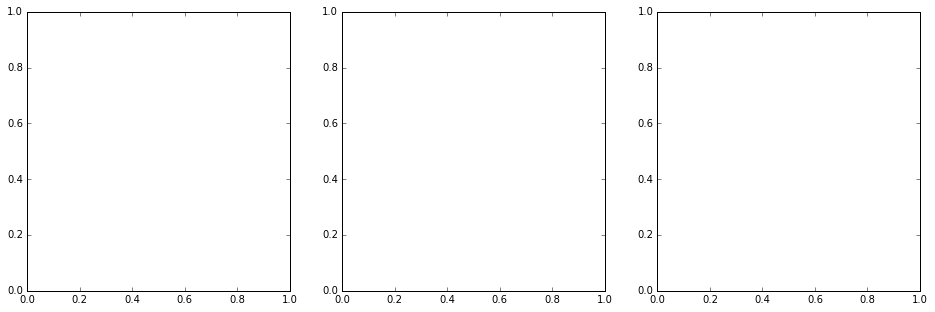

In [49]:
uu, vv,trans = transport_calculate(U,V,lon,lat)

In [36]:
vv['Oct2014OnlyRiver']['t_ind_low'][0,0,0]

0.030916791

In [10]:
U['Oct2014OnlyRiver']

<class 'netCDF4._netCDF4.Variable'>
float32 vozocrtx(time_counter, depthu, y, x)
unlimited dimensions: y, x
current shape = (744, 40, 130, 157)
filling on, default _FillValue of 9.969209968386869e+36 used

In [11]:
80-25

55